# Color-Magnitude Investigation
- if something seems to be missing, can check Color-Mag.ipynb (ex. work thus far on turnover at bright values)
    - and FinalFigures
- this notebook mostly focuses on loop metric
- 'weird' part is that methodology about aligning qualitative looping to quantification, but qualitative not always clear/not sure how to define
- show a few weird/interesting profiles
- see note below, but key is that qualitative looping sources **all type 1, 2, or transition**
    - the 'false positive' type 3 ones do sort of have looping but not in a similar way
    - also, V and I band behavior are more aligned in type 3 sources, in that the features in each seem to happen concurrently
- also have more approx. qualitative and quantitative division of two types of loops, which I even did before creating/finishing the super-orbital types *but* they align with type 1 and 2 features

In [1]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb
import scipy.stats as st
import wotan
import warnings
warnings.filterwarnings("ignore")

import ogle as o #module


blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

cross = Table.read('sourcefiles.csv')
full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')
summ = pd.read_csv('allsummtab.csv')
cross['Part'] = 1
cross2 = Table.read('part2files.csv')
cross2 = join(cross2,full,keys='src_n')
cross2['Part'] = 2
allcross = vstack(cross,cross2)

In [2]:
def carrow(vband,interp,retvect=False,fs=(6,4)):
    '''Add option to first get LCs and interpolated I'''
    vi = vband['V mag']-interp
    plt.figure(figsize=fs)
    plt.scatter(vi,interp,color=pink)
    #vectors
    yvect = interp[1:]-interp[:-1]
    xvect = vi[1:]-vi[:-1]
    plt.quiver(vi[:-1],interp[:-1],xvect,yvect,angles='xy',scale_units='xy',scale=1,color='darkseagreen',alpha=0.5)
    #flip I mag axis
    maxi,mini = np.max(interp),np.min(interp)
    plt.ylim(maxi+.02,mini-.02)
    plt.ylabel('I mag',fontsize=13)
    plt.xlabel('V-I',fontsize=13)
    if retvect: return xvect,yvect

In [3]:
def mono_count(bdf,fdf,divide=True,minimum=3,col='residual',useboth=False):
    '''Count how many points in residuals of bright df are following monotonic trends
    generalized by not first identifying peaks
    divide: divide number of monotonic by total number of points
    using decreasing to increasing since I band flipped (even though looks like opposite on plot)'''
    #combine tables if divide False; set same variable name just to bdf if not
    if useboth: df = pd.concat([bdf,fdf])
    else: df = bdf
    #make sure df sorted by time
    df = df.sort_values(by='day')
    #double check that days in order
    if not o.monotonic(df['day']):print('days not in order')
    #try to quantify loopiness by counting how many points before and after peaks are monotonic
    num_mon = 0 #counter for monotonic
    i = 0 #begin with first point
    #number of immediate switches from monotonically increasing to monotonically decreasing
    #decide whether to also test the opposite
    nswitch = 0
    this_inc = False
    #repeat for points after peak
    while i+2 < len(df[col]): 
        sub = 2
        mono = True
        while mono and i+sub<len(df[col]):
            #saves whether or not previous monotonic trend was increasing
            mono,inc = o.monotonic(df[col][i:i+sub],retwhich=True)
            #be careful since I band flipped
            if mono: this_inc = not inc #final inc that's saved is during monotonicity
            sub+=1
        #add to num_mon based on what sub left off on; it automatically gets to 3
        if sub-1>minimum: #minimum 3 passes as long as sub is 4
            #subtracts 3 b/c sub automatically gets there
            num_mon += sub-3 #adds nothing if there aren't monotonic points of at least minimum
            #add to nswitch if this round was not increasing, last round was increasing, and last round is usable (min points) 
            if this_inc: #if it was increasing right before the start
                #look ahead to determine if it switches to monotonic decreasing
                mon,tinc = o.monotonic(df[col][i+sub-2:i+sub+1+(minimum-3)],retwhich=True)
                #put not tinc back in?
                if mon and tinc: #if next three monotonically decreasing, add 1 to number of switches
                    nswitch+=1
        #now reset i to i+sub to start again
        i += sub-2 #adds 1 if no monotonic behavior
    if divide: return num_mon/len(df),nswitch
    return num_mon,nswitch

In [4]:
#bin df from res_brightness
def bindf(bright,npoints=2,res=True):
    '''bin df from res_brightness, so columns should be day, I, V-I, and residual'''
    dsplit = np.array_split(bright['day'],len(bright)/npoints)
    newd = []
    for d in dsplit:
        dmean = np.mean(d)
        newd.append(dmean)
    isplit = np.array_split(bright['I'],len(bright)/npoints)
    newi = []
    for i in isplit:
        imean = np.mean(i)
        newi.append(imean)
    visplit = np.array_split(bright['V-I'],len(bright)/npoints)
    newvi = []
    for vi in visplit:
        vimean = np.mean(vi)
        newvi.append(vimean)
    columns = ['day','I','V-I']
    if res:
        newr = []
        rsplit = np.array_split(bright['residual'],len(bright)/npoints)
        for r in rsplit:
            rmean = np.mean(r)
            newr.append(rmean)
            columns = ['day','I','V-I','residual']
    newdf = pd.DataFrame(columns = columns)
    newdf['day'] = newd
    newdf['I'] = newi
    newdf['V-I'] = newvi
    if res: newdf['residual'] = newr
    return newdf

In [5]:
def res_brightness(srcn,frac=0.5,iband=[],vband=[],interp=[],plot=False,plotres=False,plotrestime=False,retswitch=False,printall=True,retdf=False,
                   div=True,retmono=True,retslope=False,retres=False,useboth=False,minmono=3,monocol='residual',binres=1):
    '''Fit line to brightest half and faintest half of points and compare residuals from those lines
    retmono: include fraction of points in residual vs. time of bright part of color-mag that are changing monotonically
    retslope: return difference in slopes of best fit lines to bright and faint parts of I vs. V-I (currently can only do if both retmono and retslope, so change if need be)
    minmono: minimum number of points with monotonic change to be counted
    retres: return mean bright and faint residuals (no absolute values so want it to be higher/around the same at faint)
        - may be useful in tandem with absolute version
    binres: how many points per bin (if 1, do nothing)'''
    if len(iband)<1 and len(vband)<1 and len(interp)<1:
        try: iband, vband = o.getIV(srcn,cross,stack=True,plot=plot,mlist=mlist1)
        except: iband, vband = o.getIV(srcn,cross2,stack=True,plot=plot,mlist=mlist2)
        interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)
        if not plot: plt.close()

    #frame with Iint, Vmag, and V-I
    color = pd.DataFrame(columns=['day','I','V','V-I','residual'])
    color['I'],color['V'],color['V-I'] = interp,vband['V mag'],vband['V mag']-interp
    color['day'] = vband['MJD-50000']
    
    maxi,mini = np.max(interp),np.min(interp)
    #cutoff measured from max (faint), so large frac yields smaller bright frame
    bright = color[color['I']<(maxi-(maxi-mini)*frac)]
    faint = color[color['I']>(maxi-(maxi-mini)*frac)]

    #fit line to I vs. V-I for bright and faint values
    bmod = np.polyfit(bright['V-I'],bright['I'],1)
    fmod = np.polyfit(faint['V-I'],faint['I'],1)
    
    #expected values using linear fit
    expectb = bright['V-I']*bmod[0] + bmod[1]
    expectf = faint['V-I']*fmod[0] + fmod[1]
    
    #find residuals from best fit -- preserve sign
    bright['residual'] = bright['I'] - expectb
    faint['residual'] = faint['I'] - expectf
    
    #check if binres is auto, in which case replace based on number of points in bright
    if binres=='auto':
        binres = int(len(bright)/20)
        if binres==0: binres=1
        if printall: print(f'binning every {binres} points')

    #plot residual vs. I mag
    if plotres:
        plt.figure(figsize=(8,5))
        mind,maxd = np.min(color['day']),np.max(color['day'])
        plt.scatter(bright['I'],bright['residual'],c=bright['day'],cmap='plasma',vmin=mind,vmax=maxd)
        plt.scatter(faint['I'],faint['residual'],c=faint['day'],cmap='plasma',vmin=mind,vmax=maxd)
        plt.colorbar(label='MJD-50000')
        plt.ylabel('I mag - expected I mag',fontsize=13)
        plt.xlabel('I mag',fontsize=13)
        plt.xlim(maxi+.02,mini-.02)
        
    #plot residual vs. time
    if plotrestime:   
        plt.figure(figsize=(8,5))
        plt.scatter(bright['day'],bright['residual'],c=bright['I'],cmap='plasma')
        plt.ylabel('I mag - expected I mag',fontsize=13)
        plt.xlabel('Day')
        plt.colorbar(label='I mag')
        
    #return tables
    if retdf: 
        if binres > 1:
            #overwrites table
            bright = bindf(bright,npoints=binres,res=False) #res = False since no residuals calculated
        bright.sort_values(by='day',ascending=True)
        return bright
    #mean of abs value 
    #changed from sum of squares to make values larger
    bsum = np.mean(np.abs(bright['residual']))
    fsum = np.mean(np.abs(faint['residual']))
    
    #if retres, also calcuate without taking abs value
    if retres:
        or_bmean = np.mean(bright['residual'])
        or_fmean = np.mean(faint['residual'])
    if printall: 
        print(f'faint sum of abs residuals: {fsum}')
        print(f'bright sum of abs residuals: {bsum}')
        
    #fit line to bright residuals vs. I mag
    resmod = np.polyfit(bright['I'],bright['residual'],1)
    fresmod = np.polyfit(faint['I'],faint['residual'],1)
    
    #make list of returns since so  many options
    retlist = [bsum,fsum,resmod[0]-fresmod[0]] #returned no matter what
    if retmono:
        if binres > 1:
            #overwrites tables
            bright = bindf(bright,npoints=binres)
            if useboth: faint = bindf(faint,npoints=binres)
        mono_frac,nswitch = mono_count(bright,faint,divide=div,minimum=minmono,col=monocol,useboth=useboth)
        retlist.append(mono_frac)
        if retswitch:retlist.append(nswitch)
    if retslope:
        retlist.append(bmod[0]-fmod[0])
    if retres: 
        retlist.append(or_bmean)
        retlist.append(or_fmean)
    return retlist

In [6]:
def cm(s):
    try: iband, vband = o.getIV(s,cross,stack=True,plot=True,mlist=mlist1)
    except: iband, vband = o.getIV(s,cross2,stack=True,plot=True,mlist=mlist2)
    interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)

(-0.1, 0.8)

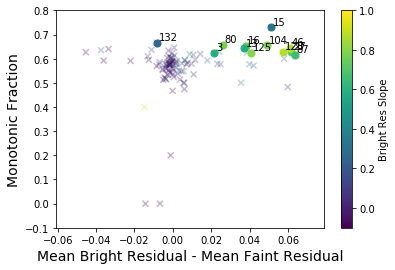

In [12]:
plt.scatter(summ['mean abs bright residual']-summ['mean abs faint residual'],summ['bright res monotonic frac'],alpha=0.3,c=summ['residual slope diff'],vmin=-.1,vmax=1,marker='x',label='all sources')
loops = [3,15,16,13,27,46,125,80,87,132,128,104] #some identified these as loops by eye
for l in loops:
    row = summ[summ['src_n']==l]
    plt.scatter(row['mean abs bright residual']-row['mean abs faint residual'],row['bright res monotonic frac'],c=row['residual slope diff'],s=50,vmin=-.1,vmax=1,marker='o')
    #annotate with source number to make follow-up easier
    plt.annotate(str(l),xy=(row['mean abs bright residual']-row['mean abs faint residual']+.001,row['bright res monotonic frac']+.01))
#cutting out outlier
# plt.xlim(0.45,0.75)
plt.colorbar(label='Bright Res Slope')
plt.xlabel('Mean Bright Residual - Mean Faint Residual',fontsize=14)
plt.ylabel('Monotonic Fraction',fontsize=14)
plt.ylim(-.1,0.8)

In [7]:
mlist1 = ['OII I','OIII I']
mlist2 = ['OII I','OIII I','OIV I']

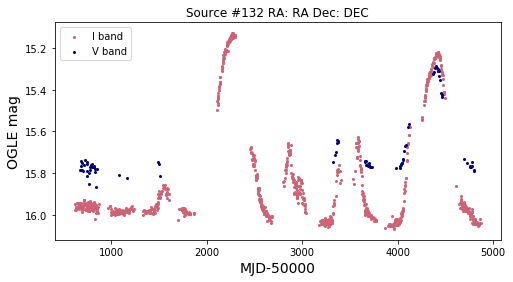

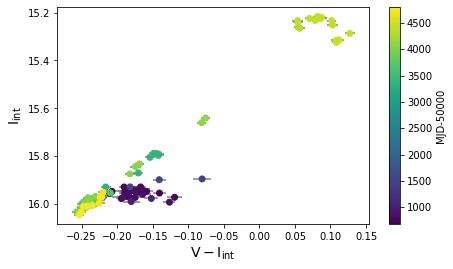

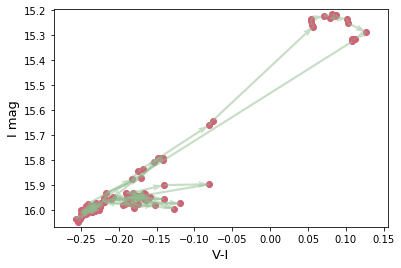

In [15]:
try: iband, vband = o.getIV(132,cross,stack=True,plot=True,mlist=mlist1)
except: iband, vband = o.getIV(132,cross2,stack=True,plot=True,mlist=mlist2)
interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)

carrow(vband,interp,retvect=False,fs=(6,4))

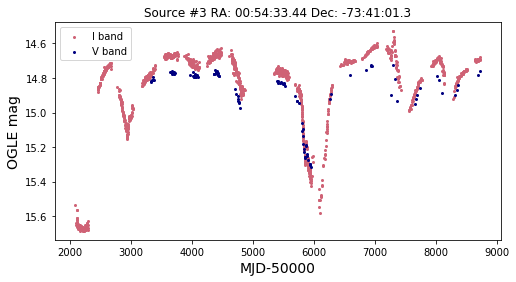

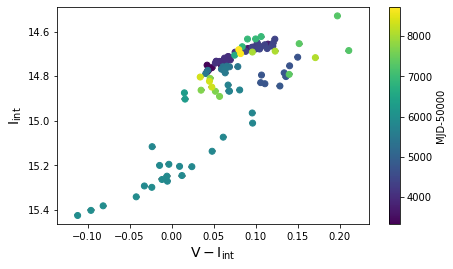

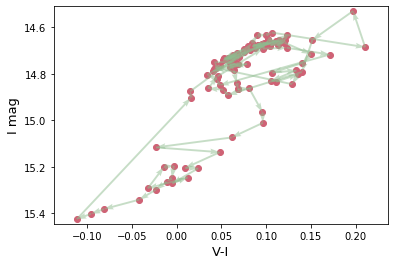

In [16]:
#type 2s often have loops that look more like this
try: iband, vband = o.getIV(3,cross,stack=True,plot=True,mlist=mlist1)
except: iband, vband = o.getIV(3,cross2,stack=True,plot=True,mlist=mlist2)
interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)

carrow(vband,interp,retvect=False,fs=(6,4))

(-0.1, 0.8)

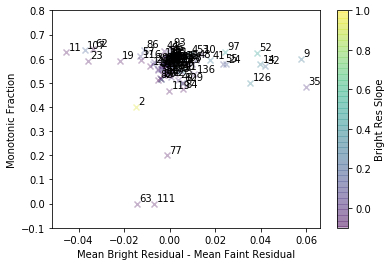

In [18]:
for s in summ['src_n']:
    if s not in loops:  
        row = summ[summ['src_n']==s]
        plt.scatter(row['mean abs bright residual']-row['mean abs faint residual'],row['bright res monotonic frac'],alpha=0.3,c=row['residual slope diff'],vmin=-.1,vmax=1,marker='x')
        #annotate with source number to make follow-up easier
        plt.annotate(str(s),xy=(row['mean abs bright residual']-row['mean abs faint residual']+.001,row['bright res monotonic frac']+.01))
#cutting out outlier
# plt.xlim(0.45,0.75)
plt.colorbar(label='Bright Res Slope')
plt.xlabel('Mean Bright Residual - Mean Faint Residual')
plt.ylabel('Monotonic Fraction')
plt.ylim(-.1,0.8) #use same y limit

just going through some other interesting/border cases from similar parameter spaces
- e.g. good that transition like 52 has loop behavior as well

(14.75, 14.65)

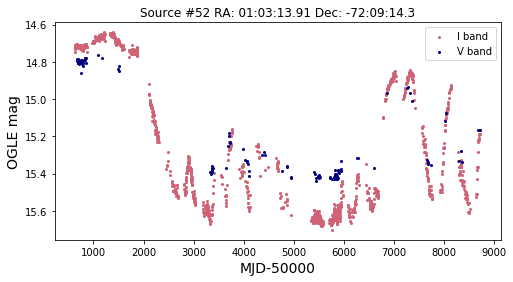

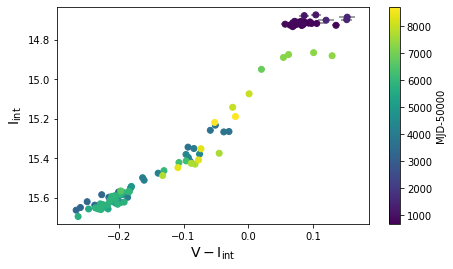

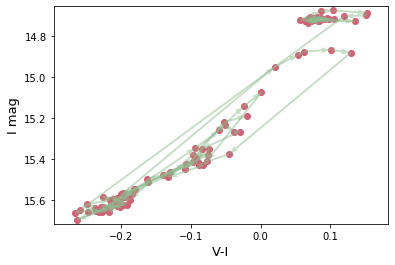

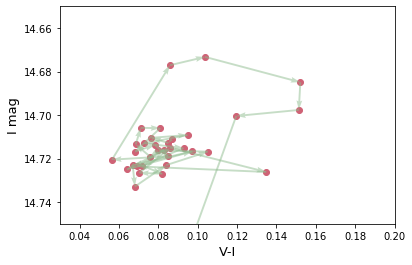

In [24]:
#and the loop happens during type 1
try: iband, vband = o.getIV(52,cross,stack=True,plot=True,mlist=mlist1)
except: iband, vband = o.getIV(52,cross2,stack=True,plot=True,mlist=mlist2)
interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)
carrow(vband,interp,retvect=False,fs=(6,4))
#plot color-mag again zoomed in on top turn-over
carrow(vband,interp,retvect=False,fs=(6,4))
plt.xlim(0.03,.2)
plt.ylim(14.75,14.65)

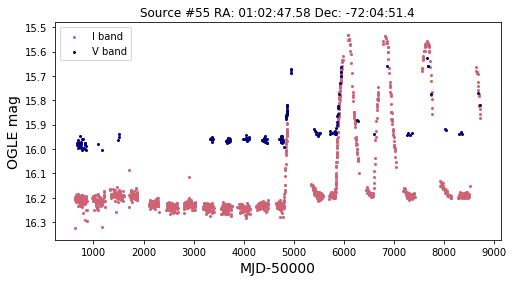

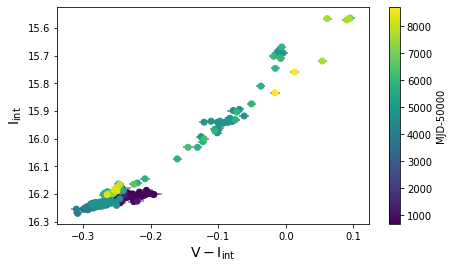

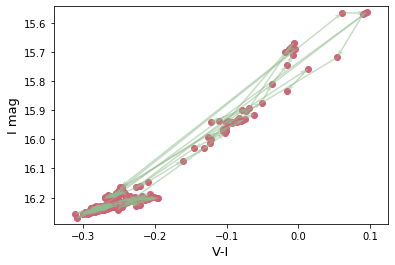

In [25]:
#not a lot of coverage but shows loop
try: iband, vband = o.getIV(55,cross,stack=True,plot=True,mlist=mlist1)
except: iband, vband = o.getIV(55,cross2,stack=True,plot=True,mlist=mlist2)
interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)
carrow(vband,interp,retvect=False,fs=(6,4))

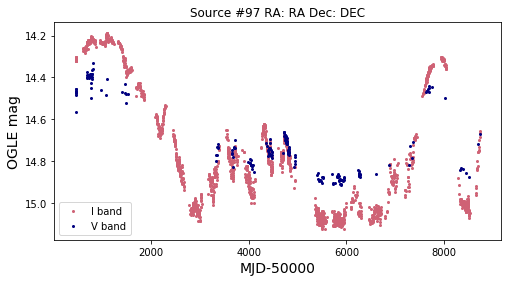

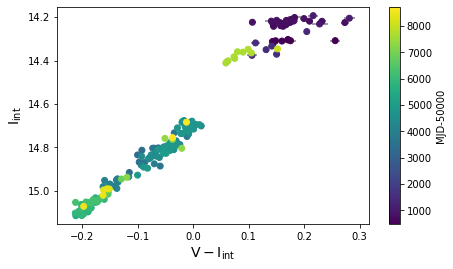

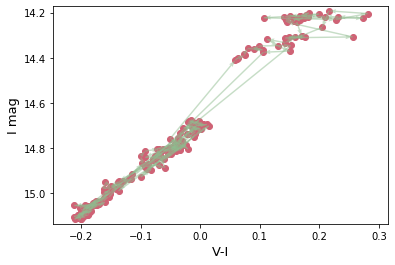

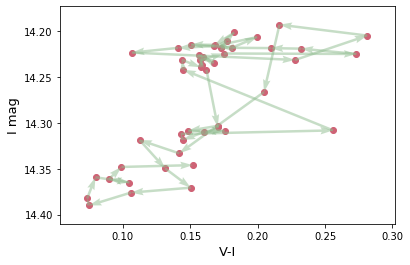

In [26]:
#similar to 52 as expected
try: iband, vband = o.getIV(97,cross,stack=True,plot=True,mlist=mlist1)
except: iband, vband = o.getIV(97,cross2,stack=True,plot=True,mlist=mlist2)
interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)
carrow(vband,interp,retvect=False,fs=(6,4))

#zoom in on top part to inspect for loops
vband['I'] = interp
vband2 = vband[vband['I']<14.4]
carrow(vband2,vband2['I'],retvect=False,fs=(6,4))

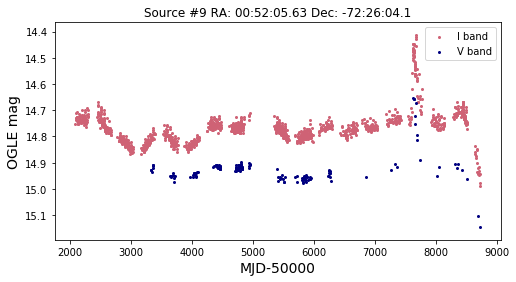

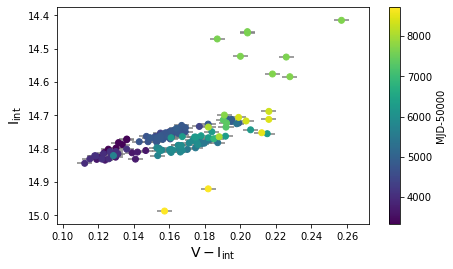

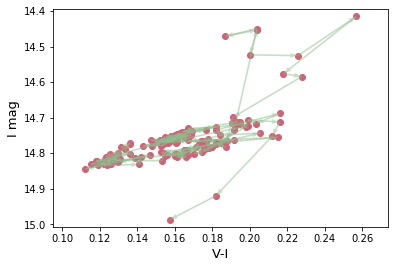

In [28]:
# certainly interesting color-mag but not really loops
try: iband, vband = o.getIV(9,cross,stack=True,plot=True,mlist=mlist1)
except: iband, vband = o.getIV(9,cross2,stack=True,plot=True,mlist=mlist2)
interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)
carrow(vband,interp,retvect=False,fs=(6,4))

(15.5, 15.3)

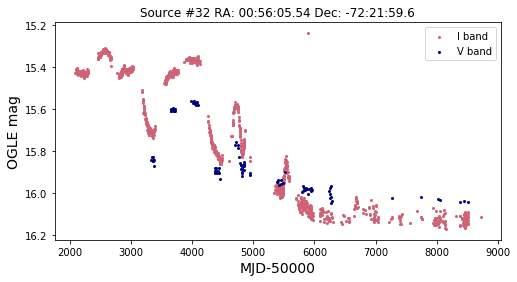

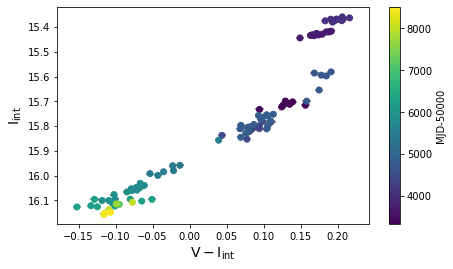

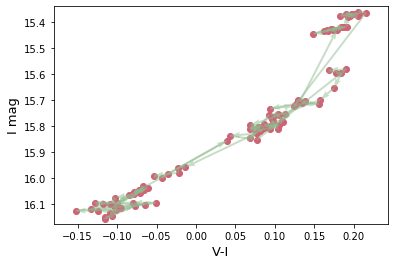

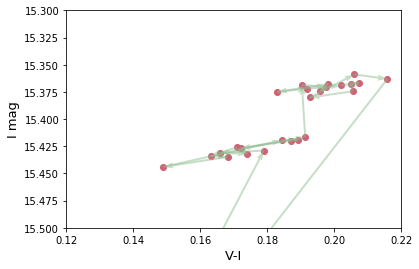

In [30]:
try: iband, vband = o.getIV(32,cross,stack=True,plot=True,mlist=mlist1)
except: iband, vband = o.getIV(32,cross2,stack=True,plot=True,mlist=mlist2)
interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)
carrow(vband,interp,retvect=False,fs=(6,4))
carrow(vband,interp,retvect=False,fs=(6,4))
plt.xlim(.12,.22)
plt.ylim(15.5,15.3)

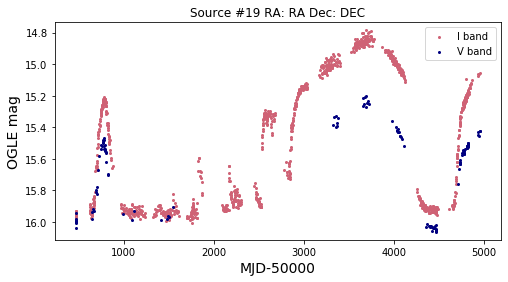

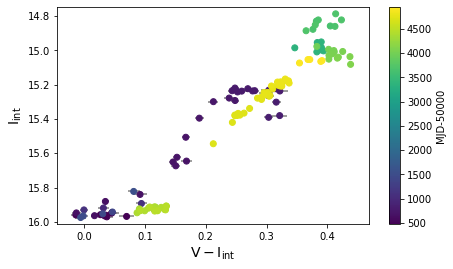

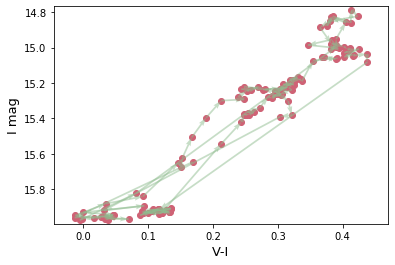

In [31]:
#has type 1 loop at beginning
try: iband, vband = o.getIV(19,cross,stack=True,plot=True,mlist=mlist1)
except: iband, vband = o.getIV(19,cross2,stack=True,plot=True,mlist=mlist2)
interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)
carrow(vband,interp,retvect=False,fs=(6,4))

In [35]:
a = sorted(np.array(summ['src_n']))
a

[2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 30,
 31,
 32,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 67,
 68,
 69,
 71,
 72,
 73,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 84,
 85,
 86,
 87,
 93,
 95,
 96,
 97,
 98,
 100,
 101,
 104,
 105,
 106,
 107,
 111,
 114,
 115,
 116,
 119,
 121,
 123,
 124,
 125,
 126,
 128,
 129,
 132,
 133,
 136,
 138,
 139,
 141,
 142]

In [10]:
def div_cm(srcn,cross=allcross,interp=[],vband=[],frac=0.5,plot=False,findcorr=False,retline=False,printall=False,retflag=False):
    '''Divide color mag by middle of Iint range and fit separately.
    specify fraction of range from faintest point to include in faint piece
    if frac is greater than 1, take it to be number of points rather than fraction of brightness
    retflag: in final return, gives 0 if brightest points not monotonically changing in V-I (in time); 1 if inc; 2 if dec'''
    #get LCs within function 
    if len(interp)==0:
        try: iband, vband = o.getIV(srcn,cross,stack=True,plot=False,mlist=mlist1)
        except: iband, vband = o.getIV(srcn,cross2,stack=True,plot=False,mlist=mlist2)
        interp = o.colormag(iband,vband,plot=False,printcorr=printall)
    #add interpolated I to V table
    vband['I int'] = interp
    if frac<1:
        #divide into two using interp range
        irange = np.max(interp)-np.min(interp)
        split = np.max(interp) - irange*frac
        #lower interp
        vbright = vband[vband['I int']<=split]
        vfaint = vband[vband['I int']>=split]
    #if frac is greater than 1, use it to put a number of points into the bright frame
    else:
        #sort by I (lowest (brightest)values first)
        vband.sort('I int')
        vbright = vband[:frac]
        vfaint = vband[frac:]
    #bright half linear best fit
    bmod = np.polyfit(vbright['V mag'] - vbright['I int'],vbright['I int'],1)
    blinmod = (vbright['V mag'] - vbright['I int'])*bmod[0]+bmod[1]
    #faint part
    fmod = np.polyfit(vfaint['V mag'] - vfaint['I int'],vfaint['I int'],1)
    flinmod = (vfaint['V mag'] - vfaint['I int'])*fmod[0]+fmod[1]
    
    #figure out if brightest points have inc,dec, or neither V-I with time
    if retflag:
        #sort bright table by time
        vbright.sort('MJD-50000')
        #add V-I as column for ease
        vbright['V-I'] = vbright['V mag'] - vbright['I int']
        #check if V-I decreasing with time
        if o.non_increasing(vbright['V-I']): flag = 2
        elif o.non_decreasing(vbright['V-I']): flag = 1
        else: flag = 0
        
    if plot: #plot color-mag with two linear best fits
        plt.scatter(vfaint['V mag'] - vfaint['I int'],vfaint['I int'],color='black',s=4)
        plt.scatter(vbright['V mag'] - vbright['I int'],vbright['I int'],color='maroon',s=4)
        maxi,mini = np.max(interp),np.min(interp)
        plt.ylim(maxi+.01,mini-.01)
        plt.plot(vfaint['V mag'] - vfaint['I int'],flinmod)
        plt.plot(vbright['V mag'] - vbright['I int'],blinmod)
    if not findcorr:
        if np.abs(fmod[0])>np.abs(bmod[0]) and printall: print('steeper when fainter')
        elif np.abs(fmod[0])<np.abs(bmod[0]) and printall: print('steeper when brighter')
        #list of returns since a few options
        rets = []
        if retline: rets.append(fmod);rets.append(bmod)
        else: rets.append(fmod[0]);rets.append(bmod[0])
        if retflag: rets.append(flag)
        return rets
    #find correlation coefficients as another check
    else:
        fcorr = np.corrcoef(vfaint['V mag']-vfaint['I int'],vfaint['I int'])[1][0]
        bcorr = np.corrcoef(vbright['V mag']-vbright['I int'],vbright['I int'])[1][0]
        return (fcorr**2,fmod[0]),(bcorr**2,bmod[0])

In [14]:
#add bright and faint half best slopes and intercepts to summtab
sort_srcs = sorted(np.array(summ['src_n']))
fslopes,fints,bslopes,bints = [],[],[],[]
for s in sort_srcs:
    try: fmod,bmod = div_cm(s,cross=allcross,interp=[],vband=[],frac=0.5,plot=False,findcorr=False,retline=True,printall=False)
    except: 
        fmod,bmod = [np.nan,np.nan],[np.nan,np.nan]
        print(f'source {s} not found')
    fslopes.append(fmod[0]);bslopes.append(bmod[0]);fints.append(fmod[1]);bints.append(bmod[1])

empty file for OIII I
source 51 not found
empty file for OII I
empty file for OIII I


In [15]:
hl = pd.DataFrame(columns=['faint slope','faint int','bright slope','bright int'])#half lines
hl['faint slope'] = fslopes
hl['bright slope'] = bslopes
hl['faint int'] = fints
hl['bright int'] = bints

In [16]:
#don't necessarily need to re-run; just now in table (see below)
useboth = False
fsums,bsums,slopes,fracs,nswitch,sdiff = [],[],[],[],[],[]
for s in sort_srcs:
    try: #skips 1,51,78
        b,f,bslope,mfrac,ns,sd = res_brightness(s,plot=False,printall=False,frac=0.5,retslope=True,div=False,minmono=3,monocol='residual',useboth=useboth,retswitch=True,binres=1)
        fsums.append(f);bsums.append(b);slopes.append(bslope);fracs.append(mfrac); sdiff.append(sd);nswitch.append(ns)
    except:
        print(f'source {s} not found')
        fsums.append(np.nan);bsums.append(np.nan);slopes.append(np.nan);fracs.append(np.nan); sdiff.append(np.nan); nswitch.append(np.nan)

empty file for OIII I
source 51 not found
empty file for OII I
source 78 not found
empty file for OIII I


In [17]:
scopy = summ.copy() #for testing
scopy['bright - faint slope'] = sdiff
scopy['number switch'] = nswitch

In [18]:
'bright - faint slope' in summ

False

In [19]:
# if useboth:
scopy['number switch'] = nswitch 
# copy summ to add temp columns
# if not useboth:
scopy['mono frac 2'] = fracs 
scopy['mean abs bright residual'] = bsums
scopy['mean abs faint residual'] = fsums
scopy['bright res monotonic frac'] = fracs
scopy['number switch'] = nswitch
scopy['residual slope diff'] = slopes
scopy['bright - faint slope'] = sdiff

Text(0, 0.5, 'Monotonic Points')

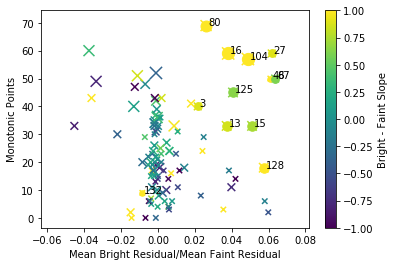

In [43]:
plt.scatter(scopy['mean abs bright residual']-scopy['mean abs faint residual'],scopy['mono frac 2'],c=scopy['bright - faint slope'],marker='x',label='all sources',vmin=-1,vmax=1,s=30*(summ['number switch']+1))
loops = [3,15,16,13,27,46,125,80,87,132,128,104]
for l in loops:
    row = scopy[scopy['src_n']==l]
    plt.scatter(row['mean abs bright residual']-row['mean abs faint residual'],row['mono frac 2'],c=row['bright - faint slope'],marker='o',vmin=-1,vmax=1,s=30*(row['number switch']+1))
    #annotate with source number to make follow-up easier
    plt.annotate(str(l),xy=(row['mean abs bright residual']-row['mean abs faint residual']+.001,row['mono frac 2']+.01))
#cutting out outlier
# plt.xlim(0.45,0.75)
plt.colorbar(label='Bright - Faint Slope')
plt.xlabel('Mean Bright Residual/Mean Faint Residual')
plt.ylabel('Monotonic Points')

In [44]:
ltab = scopy[scopy['src_n']==loops[0]]
for l in loops[1:]:
    row = scopy[scopy['src_n']==l]
    ltab = pd.concat([ltab,row])

Text(0, 0.5, 'Monotonic Fraction')

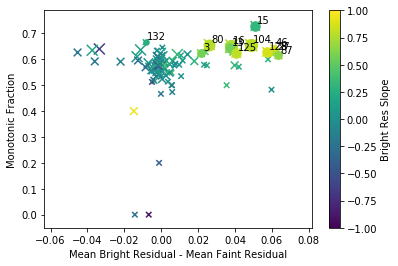

In [45]:
#repeat with fraction
plt.scatter(summ['mean abs bright residual']-summ['mean abs faint residual'],summ['bright res monotonic frac'],c=summ['residual slope diff'],marker='x',label='all sources',vmin=-1,vmax=1,s=30*(summ['number switch']+1))
loops = [3,15,16,13,27,46,125,80,87,132,128,104]
for l in loops:
    row = summ[summ['src_n']==l]
    plt.scatter(row['mean abs bright residual']-row['mean abs faint residual'],row['bright res monotonic frac'],c=row['residual slope diff'],marker='o',vmin=-1,vmax=1,s=30*(row['number switch']+1))
    #annotate with source number to make follow-up easier
    plt.annotate(str(l),xy=(row['mean abs bright residual']-row['mean abs faint residual']+.001,row['bright res monotonic frac']+.01))
#cutting out outlier
# plt.xlim(0.45,0.75)
plt.colorbar(label='Bright Res Slope')
plt.xlabel('Mean Bright Residual - Mean Faint Residual')
plt.ylabel('Monotonic Fraction')
# plt.xscale('log')

# Loop Metric

In [20]:
#for each variable, normalize to maximum
nmfrac = summ['bright res monotonic frac']/np.nanmax(summ['bright res monotonic frac'])
nresdiff = (summ['mean abs bright residual']-summ['mean abs faint residual'])/np.nanmax(summ['mean abs bright residual']-summ['mean abs faint residual'])
nslope = summ['residual slope diff']/np.nanmax(summ['residual slope diff'])

In [21]:
summ['loop metric'] = nmfrac + nresdiff + nslope #+ nswitch
#wrote out allsummtab with the addition of loop metric

Text(0.5, 0, 'bright - faint slope')

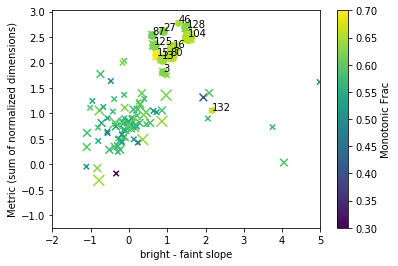

In [56]:
#now can be plotted in any notebook
plt.scatter(summ['bright - faint slope'],summ['metric'],c=summ['bright res monotonic frac'],vmin=0.3,vmax=0.7,marker='x',label='all sources',s=30*(summ['number switch']+1))
loops = [3,15,16,13,27,46,125,80,87,132,128,104]
for l in loops:
    row = summ[summ['src_n']==l]
    plt.scatter(row['bright - faint slope'],row['metric'],c=row['bright res monotonic frac'],vmin=0.3,vmax=0.7,marker='o',s=30*(row['number switch']+1))
    #annotate with source number to make follow-up easier
    plt.annotate(str(l),xy=(row['bright - faint slope']+.001,row['metric']+.01))
#cutting out outlier
# plt.xlim(0.45,0.75)
plt.colorbar(label='Monotonic Frac')
# plt.xlabel('Mean Bright Residual - Mean Faint Residual')
plt.ylabel('Metric (sum of normalized dimensions)')
#cut out outler around 18 with low mono frac
plt.xlim(-2,5)
plt.xlabel('bright - faint slope')

In [57]:
#version with fourth parameter
nslope2 = summ['bright - faint slope']/np.max(summ['bright - faint slope'])
summ['metric2'] = nmfrac + nresdiff + nslope + nslope2 #+ nswitch

Text(0, 0.5, 'Metric')

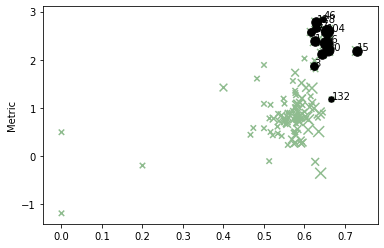

In [58]:
plt.scatter(summ['bright res monotonic frac'],summ['metric2'],color='darkseagreen',marker='x',label='all sources',s=30*(summ['number switch']+1))
loops = [3,15,16,13,27,46,125,80,87,132,128,104]
for l in loops:
    row = summ[summ['src_n']==l]
    plt.scatter(row['bright res monotonic frac'],row['metric2'],color='black',marker='o',s=30*(row['number switch']+1))
    #annotate with source number to make follow-up easier
    plt.annotate(str(l),xy=(row['bright res monotonic frac']+.001,row['metric2']+.01))
#cutting out outlier
# plt.xlim(0.45,0.75)
# plt.xlabel('Mean Bright Residual - Mean Faint Residual')
plt.ylabel('Metric')

In [61]:
#separate lists of sources for possible loop populations
loop1 = [15,128,132,52,55]
loop2 = [3,16,13,46,125,80,87,104]

In [62]:
b1 = res_brightness(15,plot=False,retdf=True,printall=False,frac=0.5,retslope=True,div=True,minmono=3,monocol='residual',useboth=useboth,retswitch=True,binres=1)

In [63]:
b2 = res_brightness(3,plot=False,retdf=True,printall=False,frac=0.5,retslope=True,div=True,minmono=3,monocol='residual',useboth=useboth,retswitch=True,binres=1)

In [64]:
def compare(xcol = 'bright res monotonic frac',ycol = 'bright - faint slope',table=summ):
    for l in loop1:
        row = table[table['src_n']==l]
        plt.scatter(row[xcol],row[ycol],color='black')
        #annotate
        plt.annotate(str(l),xy=(row[xcol],row[ycol]))

    for l in loop2:
        row = table[table['src_n']==l]
        plt.scatter(row[xcol],row[ycol],color='darkseagreen')
        #annotate
        plt.annotate(str(l),xy=(row[xcol],row[ycol]))
    plt.ylabel(ycol,fontsize=13);plt.xlabel(xcol,fontsize=13)

## a couple ways to divide types of loops
- notice correlation to type 1 vs. type 2/other sources

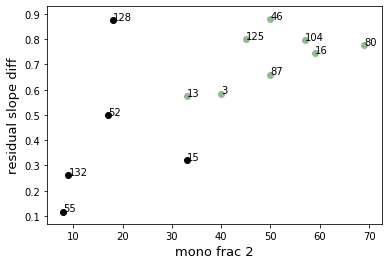

In [65]:
compare(ycol='residual slope diff',xcol='mono frac 2',table=scopy)

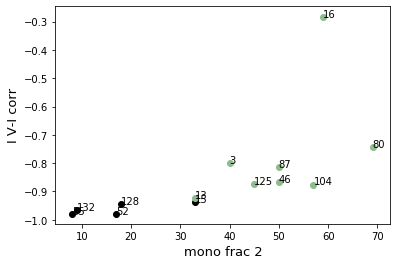

In [66]:
#best one
compare(ycol='I V-I corr',xcol='mono frac 2',table=scopy)

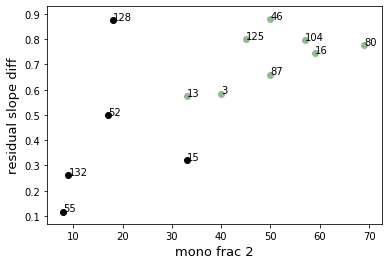

In [67]:
compare(ycol='residual slope diff',xcol='mono frac 2',table=scopy)

## specifically investigate based on super-orbital types
- 1 and 2 in particular

In [128]:
type1 = o.gettype(alls,num='1')
type2 = o.gettype(alls,num='2')
type3 = o.gettype(alls,num='3')
type4 = [60,63]
type5 = o.gettype(alls,num='5')+[5,6,9,10]
type6 = o.gettype(alls,num='6')
type7 = o.gettype(alls,num='7')

typet = []
for i in range(len(alls)):
    row = alls.iloc[i]
    src = row['src_n']
    if '+' in str(row['type']):
        typet.append(int(src))

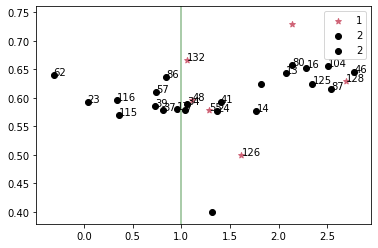

In [110]:
o.tplot(type1,summ,text=True,label='1',marker='*',color=pink,x='metric',y='bright res monotonic frac')
o.tplot(type2,summ,text=True,label='2',marker='o',color='black',x='metric',y='bright res monotonic frac')
o.tplot(type3,summ,text=True,label='2',marker='o',color='black',x='metric',y='bright res monotonic frac')

# plt.text(2.18,-0.937,'15')
plt.legend()
plt.axvline(1,color='darkseagreen')

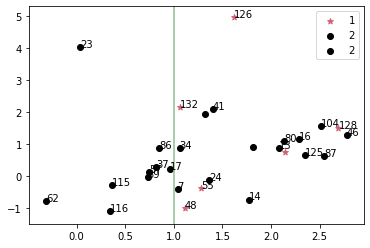

In [111]:
o.tplot(type1,summ,text=True,label='1',marker='*',color=pink,x='metric',y='bright - faint slope')
o.tplot(type2,summ,text=True,label='2',marker='o',color='black',x='metric',y='bright - faint slope')
o.tplot(type3,summ,text=True,label='2',marker='o',color='black',x='metric',y='bright - faint slope')

# plt.text(2.18,-0.937,'15')
plt.legend()
plt.axvline(1,color='darkseagreen')

In [107]:
# try: iband, vband = o.getIV(126,cross,stack=True,plot=True,mlist=mlist1)
# except: iband, vband = o.getIV(126,cross2,stack=True,plot=True,mlist=mlist2)
# interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)
# carrow(vband,interp,retvect=False,fs=(6,4))

In [108]:
def fulltplot(x='stdev I',y='det stdev I',legend=True,tbool=[False]*7,between=False,tab=summ):
    if between and len(tbool)==7: tbool.append(False) #make sure tbool is right length 
    o.tplot(type1,tab,color=pink,marker='*',label='1',x=x,y=y,text=tbool[0])
    o.tplot(type2,tab,color='black',label='2',x=x,y=y,text=tbool[1])
    o.tplot(type3,tab,color='black',marker='o',label='2',x=x,y=y,text=tbool[2])
    o.tplot(type4,tab,color='navy',marker='+',label='4',x=x,y=y,text=tbool[3])
    o.tplot(type5,tab,marker='v',label='3',color='maroon',x=x,y=y,text=tbool[4])
    o.tplot(type6,tab,marker='3',label='5',color='grey',x=x,y=y,text=tbool[5])
    o.tplot(type7,tab,color='darkseagreen',marker='h',label='6',x=x,y=y,text=tbool[6])
    #if between, also plot transition sources
    if between: o.tplot(typet,tab,marker='P',label='transition',color='rebeccapurple',x=x,y=y,text=tbool[7])
    plt.ylabel(y,fontsize=14)
    plt.xlabel(x,fontsize=14)
    if legend: plt.legend()

(-3, 6)

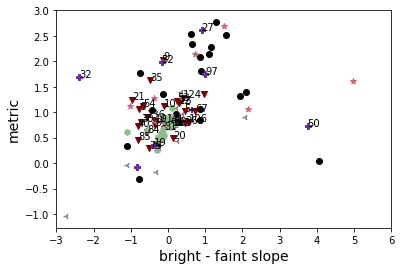

In [202]:
fulltplot(x='bright - faint slope',y='metric',between=True,legend=False,tbool=[False,False,False,False,True,False,False,True])
plt.xlim(-3,6)

In [212]:
mettab2 = summ[summ['metric2']>1.5]

In [215]:
loop1

[15, 128, 132, 52, 55]

(-0.5, 3)

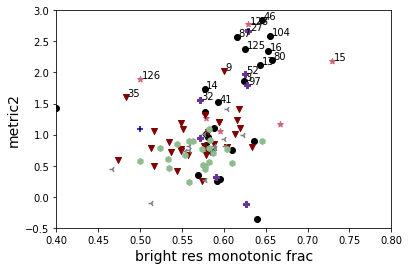

In [214]:
fulltplot(x='bright res monotonic frac',y='metric2',between=True,legend=False,tbool=[False,False,False,False,False,False,False,False])
for m in range(len(mettab2)):
    x = mettab2.iloc[m]['bright res monotonic frac']
    y = mettab2.iloc[m]['metric2']
    plt.text(x+.002,y+.01,str(mettab.iloc[m]['src_n']))
plt.xlim(0.4,0.8)
plt.ylim(-0.5,3)

In [216]:
mettab = summ[summ['metric']>1.5]
mettab[mettab['type']=='5']

,src_n,ra_deg,dec_deg,spin period,perr,est. period,sep,name,mean I,stdev I,...,stdev ratio,IQR ratio,sig stdev ratio,total days,# dips/flares,days / dip/flare,bright - faint slope,number switch,metric,metric2
30,35,16.930262,-71.99825,153.99,0.55,0.0,0.0,NaN,16.471812,0.244448,...,0.128942,0.133004,0.105007,6622.86754,0.0,0.0,-0.473891,0.0,1.63505,1.608948


(0.4, 0.8)

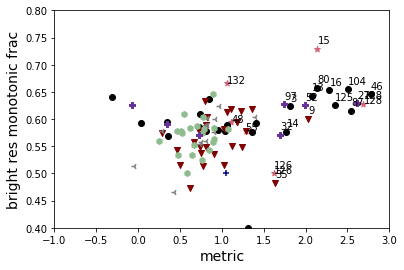

In [222]:
fulltplot(x='metric',y='bright res monotonic frac',between=True,legend=False,tbool=[True]+[False]*6)#,tbool=[True,True,True,False,False,False,False,True])
for m in range(len(mettab)):
    y = mettab.iloc[m]['bright res monotonic frac']
    x = mettab.iloc[m]['metric']
    plt.text(x+.002,y+.01,str(mettab.iloc[m]['src_n']))
plt.xlim(-1,3)
plt.ylim(.4,.8)

In [188]:
met = np.array(summ[summ['metric']>1.5]['src_n'])

In [199]:
mettab[mettab['type']=='4'] #but now in type 3

,src_n,ra_deg,dec_deg,spin period,perr,est. period,sep,name,mean I,stdev I,...,stdev ratio,IQR ratio,sig stdev ratio,total days,# dips/flares,days / dip/flare,bright - faint slope,number switch,metric,metric2
7,9,13.02375,-72.43445,7.78,0.6,44.92,0.136825,SXP 7.78,14.768247,0.063653,...,0.417335,0.277374,0.229158,6640.84271,0.0,0.0,-0.125295,0.0,2.032523,2.025622


the two sources in type 3 (old type 5/4) with a loop metric above 1.5 are src 35 and 9, shown below (doesn't really look like looping)
- although with use of arrows, does look more like noisy loop
- and they're not at high 'bright - faint slope'

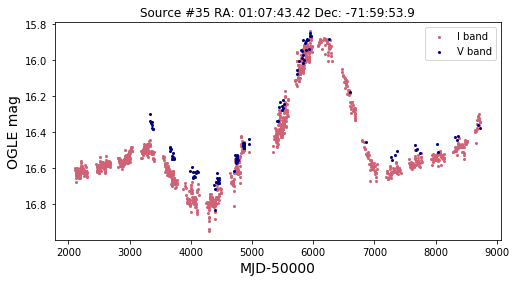

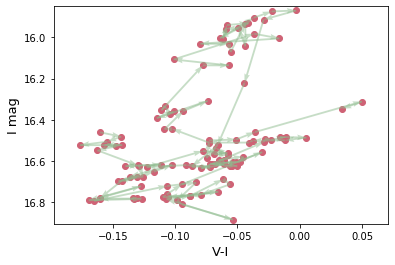

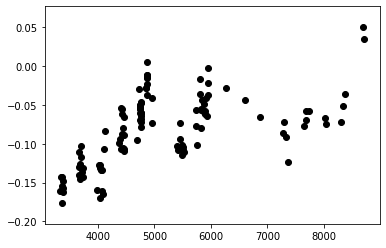

In [197]:
try: iband, vband = o.getIV(35,cross,stack=True,plot=True,mlist=mlist1)
except: iband, vband = o.getIV(35,cross2,stack=True,plot=True,mlist=mlist2)
interp = o.colormag(iband,vband,retint=True,both=False,printcorr=False,plot=False)
carrow(vband,interp,retvect=False,fs=(6,4))
plt.figure(figsize=(6,4))
plt.scatter(vband['MJD-50000'],vband['V mag']-interp,color='black') #V-I vs. time

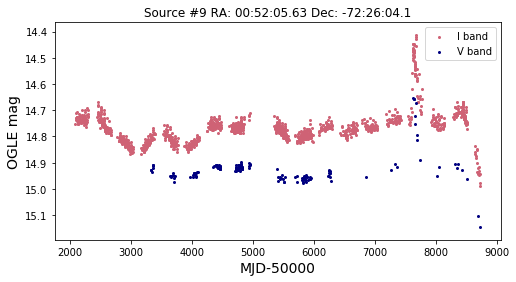

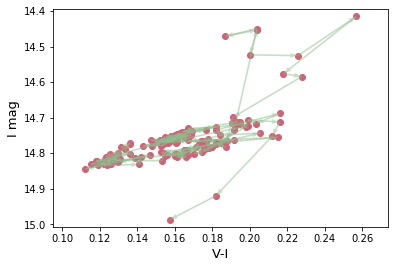

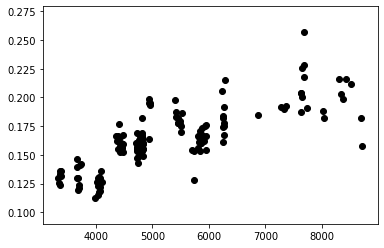

In [201]:
try: iband, vband = o.getIV(9,cross,stack=True,plot=True,mlist=mlist1)
except: iband, vband = o.getIV(9,cross2,stack=True,plot=True,mlist=mlist2)
interp = o.colormag(iband,vband,retint=True,both=False,printcorr=False,plot=False)
carrow(vband,interp,retvect=False,fs=(6,4))
plt.figure(figsize=(6,4))
plt.scatter(vband['MJD-50000'],vband['V mag']-interp,color='black') #V-I vs. time

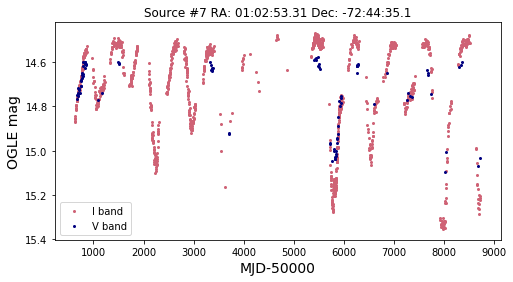

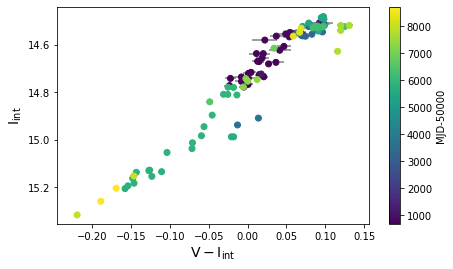

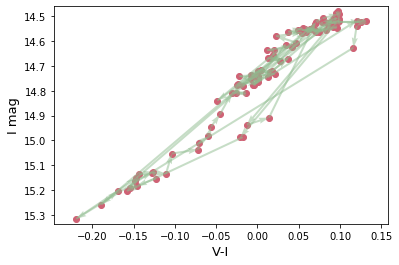

In [162]:
try: iband, vband = o.getIV(7,cross,stack=True,plot=True,mlist=mlist1)
except: iband, vband = o.getIV(7,cross2,stack=True,plot=True,mlist=mlist2)
interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)
carrow(vband,interp,retvect=False,fs=(6,4))

(15.2, 14.9)

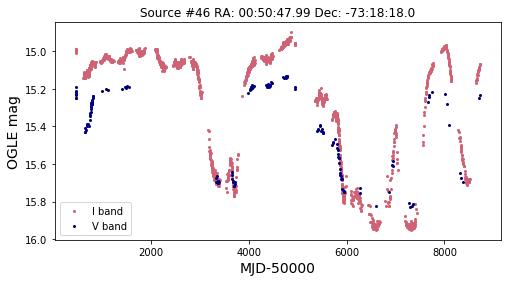

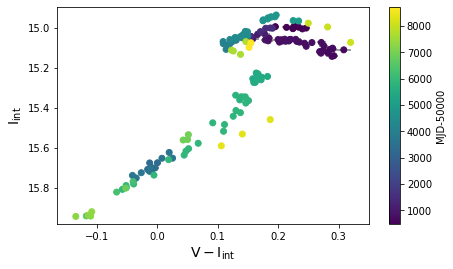

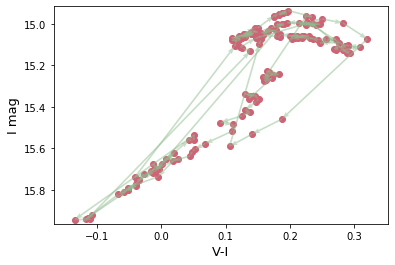

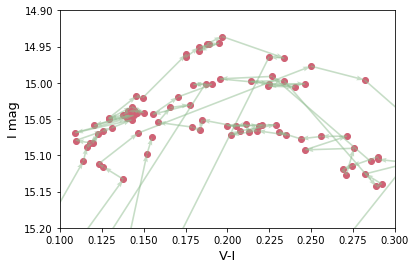

In [166]:
#has turnover/loops in both directions
try: iband, vband = o.getIV(46,cross,stack=True,plot=True,mlist=mlist1)
except: iband, vband = o.getIV(46,cross2,stack=True,plot=True,mlist=mlist2)
interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)
carrow(vband,interp,retvect=False,fs=(6,4))
carrow(vband,interp,retvect=False,fs=(6,4))
plt.xlim(0.1,0.3)
plt.ylim(15.2,14.9)

In [151]:
# for t in type5:
#     cm(t)

# Important Note:
- Type 3 sources (no base, decent variability) seem to have more agreement between V and I band shapes
    - i.e. V shape follows I shape more
    - whereas type 1 and 2 sources often have similar shapes but not on same timescale in each band
        - correlated with loops in color-mag diagram
- other potentially helpful piece: type 3 generally less variable (super-orbital variability) than types 1 and 2

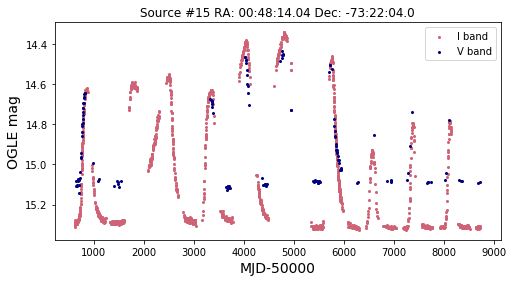

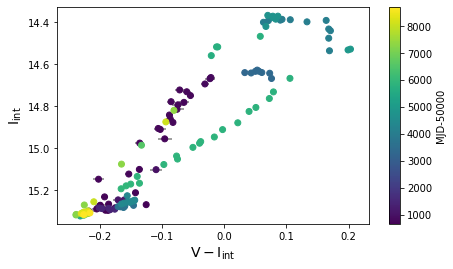

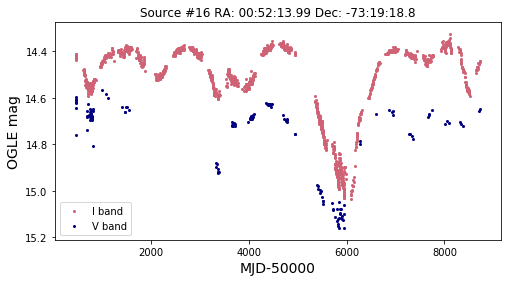

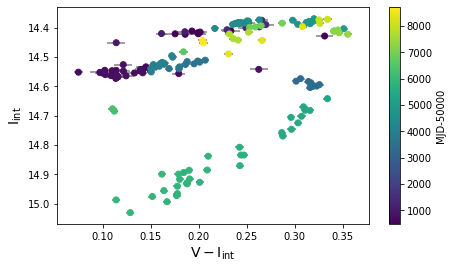

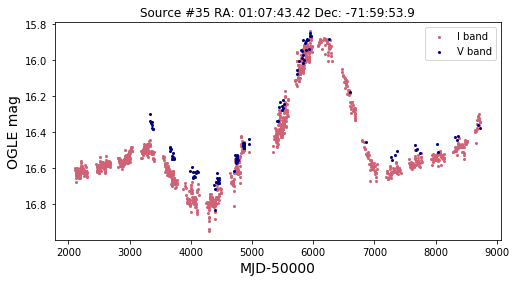

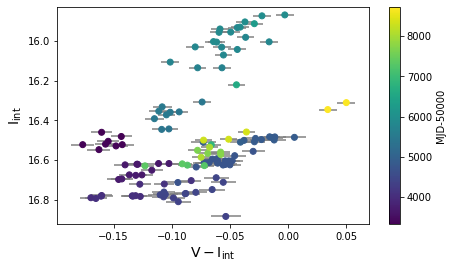

In [156]:
cm(15) #type 1 example
cm(16)#type 2 example
# plt.xlim(-.4,.4)
cm(35) #type 3 example

15 in first type of loop
48 not classified qualitatively as loop
55 in first type of loop
126 not classified qualitatively as loop
128 in first type of loop
132 in first type of loop


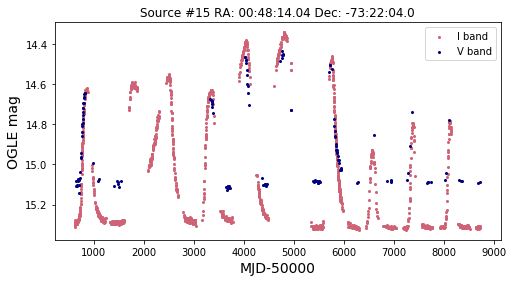

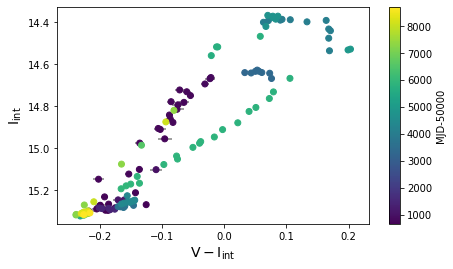

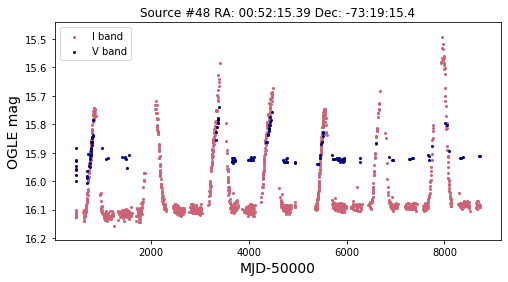

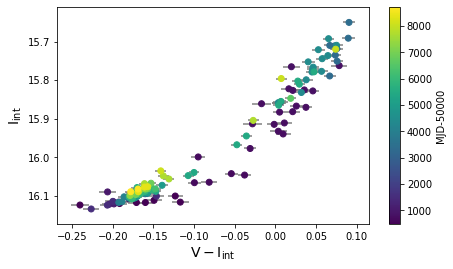

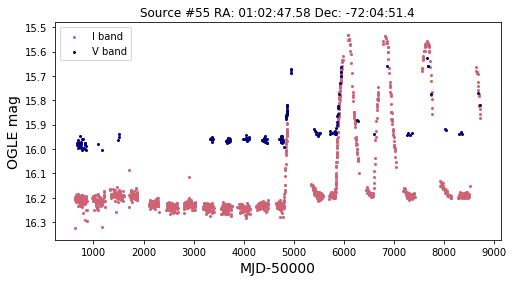

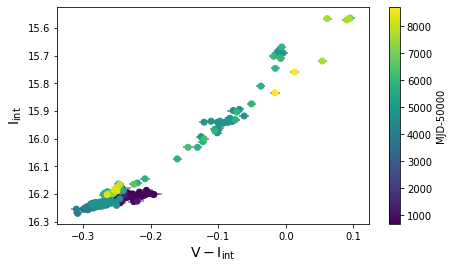

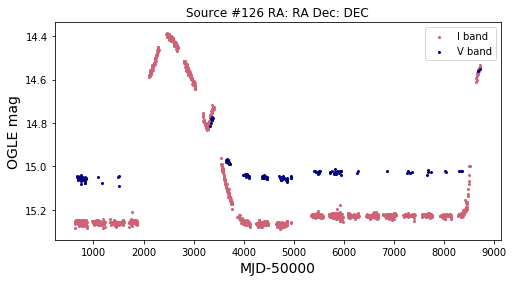

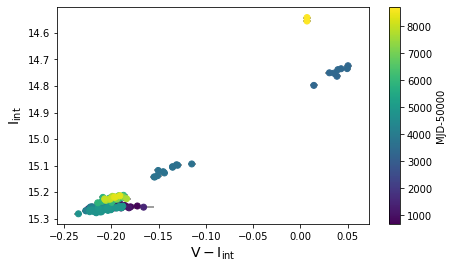

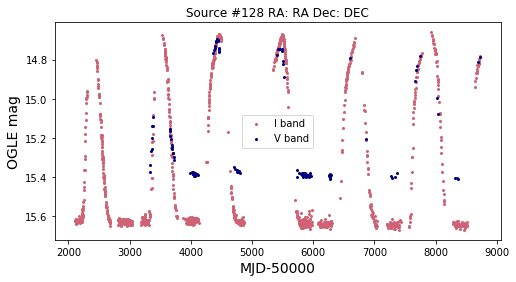

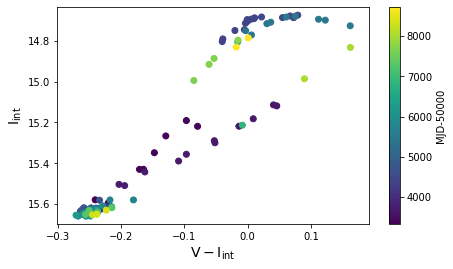

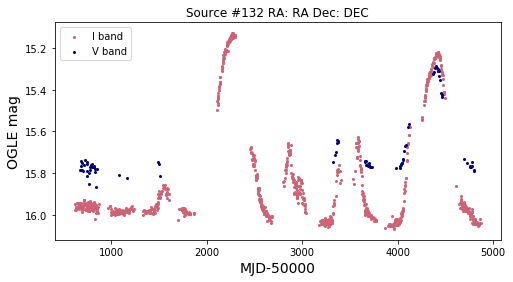

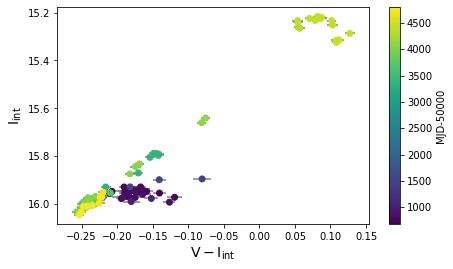

In [159]:
#satisfied with
for t in type1:
    cm(t)
    if t in loop1: print(f'{t} in first type of loop')
    elif t in loop2: print(f'{t} in first type of loop')
    else: print(f'{t} not classified qualitatively as loop')

 - 7 could be loop

In [169]:
# for t in type2:
#     cm(t)
#     if t in loop1: print(f'{t} in first type of loop')
#     elif t in loop2: print(f'{t} in second type of loop')
#     else: print(f'{t} not classified qualitatively as loop')

(14.8, 14.4)

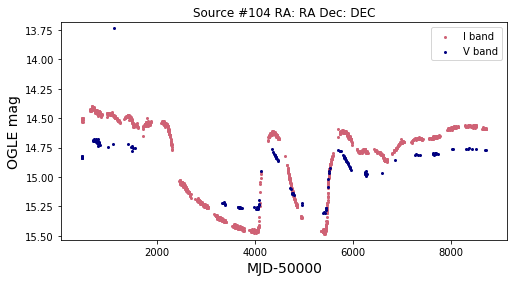

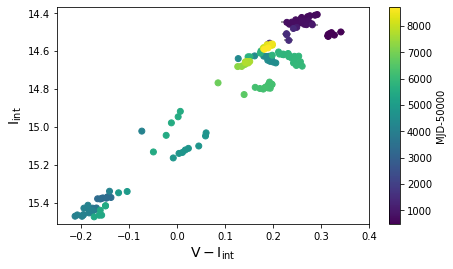

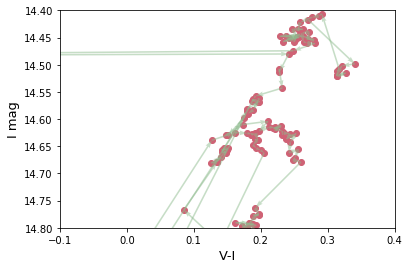

In [176]:
#classified as second type of loop but could be first
try: iband, vband = o.getIV(104,cross,stack=True,plot=True,mlist=mlist1)
except: iband, vband = o.getIV(104,cross2,stack=True,plot=True,mlist=mlist2)
interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)
plt.xlim(-.25,.4)
carrow(vband,interp,retvect=False,fs=(6,4))
plt.xlim(-.1,.4)
plt.ylim(14.8,14.4)

In [178]:
loop1

[15, 128, 132, 52, 55]

In [179]:
loop2

[3, 16, 13, 46, 125, 80, 87, 104]

In [180]:
loops

[3, 15, 16, 13, 27, 46, 125, 80, 87, 132, 128, 104]

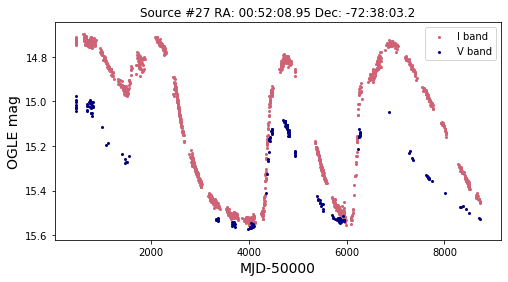

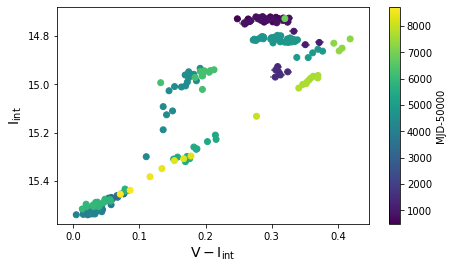

In [181]:
cm(27)

In [187]:
for l in loops:
    if l not in type1 and l not in type2 and l not in type3 and l not in typet: print(l)

## all (qualitative) loops in types 1, 2, or transition sources

# other color-mag figures can be found in FinalFigures notebook